In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
def delete_small_contours(contours):
    new_contours = []
    for contour in contours:
        if(cv2.contourArea(contour) > 10):
            new_contours.append(contour)
    return new_contours

def resize_image(img, size=(28,28)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [38]:
# Suppression du fond de l'image et préparation de la suppression des dechets plus importants


def calcMean(pixel):
  return abs(sum(pixel)/3)

def delPixel(control):
  if control < 50 or control > 180:
    return 0
  else:
    return 1

def firstProcessing(image2):

  image2 = resize_image(image2, size=(int(image2.shape[0]/4),int(image2.shape[1]/4)))

  cv2.waitKey(0)
  cv2.destroyAllWindows()
  im1 = image2
  tmp = np.zeros((len(image2), len(image2[0])))
  for i in range(len(image2)):
    for j in range(len(image2[0])):
      if calcMean(image2[i,j]) > 120 or calcMean(image2[i,j]) < 20:
        im1[i,j]=(255,255,255)

  cv2_imshow(im1)
  return im1

In [43]:

def preprocessing(img):
  image2 = firstProcessing(img)
  image2 = resize_image(image2, size=(int(image2.shape[0]/4),int(image2.shape[1]/4)))
  print(image2.shape)
  img_gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

  cv2_imshow(img_gray2)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  unique, counts = np.unique(img_gray2, return_counts=True)
  #print(np.asarray((unique, counts)).T)

  ret, thresh2 = cv2.threshold(img_gray2, 200, 255, cv2.THRESH_BINARY)

  contours4, hierarchy4 = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  image_copy5 = img_gray2.copy()

  color = int(unique[np.argmax(counts)])
  cv2.drawContours(image_copy5, delete_small_contours(contours4), -1, (255,255,255), 2, cv2.LINE_AA)
  # see the results
  cv2_imshow(image_copy5)
  #print(f"EXTERNAL: {hierarchy4}")
  cv2.waitKey(0)
  cv2.imwrite('contours_retr_external.jpg', image_copy5)
  cv2.destroyAllWindows()


  img = firstProcessing(img)
  Z = img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 5

  attemps = 10
  ret,label,centers=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  centers = np.uint8(centers)
  res = centers[label.flatten()]
  res2 = res.reshape((img.shape))

  image_copy6 = image2.copy()
  unique, counts = np.unique(label, return_counts=True)

  print(np.asarray((unique, counts)).T)
  color = (int(centers[np.argmax(counts)][0]),int(centers[np.argmax(counts)][1]),int(centers[np.argmax(counts)][2]))
  print(color)
  cv2.drawContours(image_copy6, delete_small_contours(contours4), -1, color, -1, cv2.LINE_AA)
  # see the results
  cv2_imshow(image_copy6)
  #print(f"EXTERNAL: {hierarchy4}")
  cv2.waitKey(0)
  cv2.imwrite('contours_retr_external.jpg', image_copy6)
  cv2.destroyAllWindows()
  img = image_copy6
  Z = img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2

  attemps = 10
  ret,label,centers=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  centers = np.uint8(centers)
  res = centers[label.flatten()]
  res2 = res.reshape((img.shape))
  print('t')
  cv2_imshow(res2)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  img = image2.copy()


  for contour in delete_small_contours(contours4):
      approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
      cv2.drawContours(img, [approx], 0, color, 5)
      x = approx.ravel()[0]
      y = approx.ravel()[1] - 5
      if len(approx) == 3:
          cv2.putText( img, "Triangle", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0) )
      elif len(approx) == 4 :
          x, y , w, h = cv2.boundingRect(approx)
          aspectRatio = float(w)/h
          print(aspectRatio)
          if aspectRatio >= 0.95 and aspectRatio < 1.05:
              cv2.putText(img, "square", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))

          else:
              cv2.drawContours(img,[contour], -1, color, -1, cv2.LINE_AA)

      elif len(approx) == 5 :
          cv2.putText(img, "pentagon", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
      elif len(approx) == 10 :
          cv2.putText(img, "star", (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
      else:
          cv2.drawContours(img,[contour], -1, color, -1, cv2.LINE_AA)


  cv2.imwrite('fixed/fixed image.jpg', img)







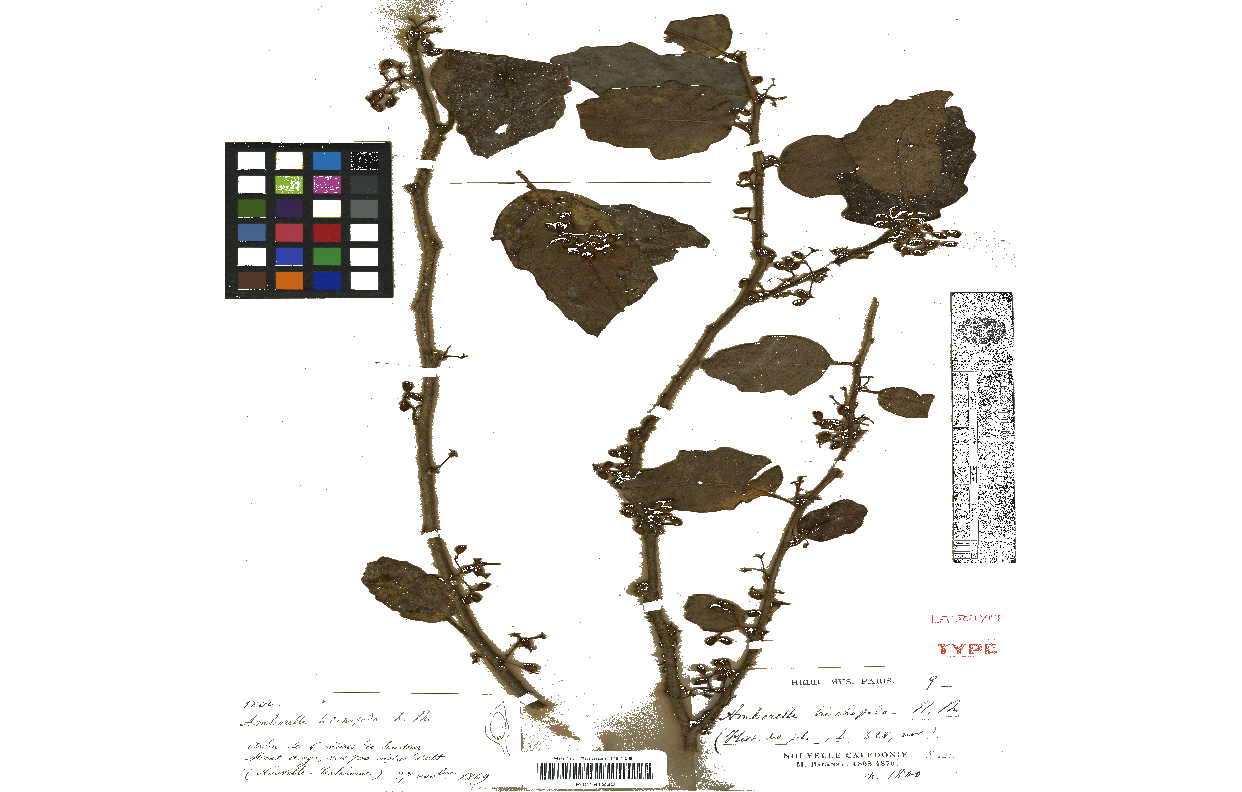

(310, 198, 3)


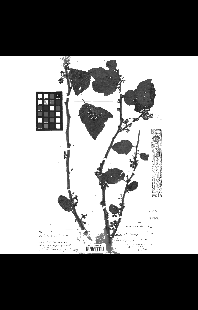

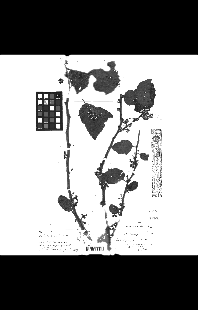

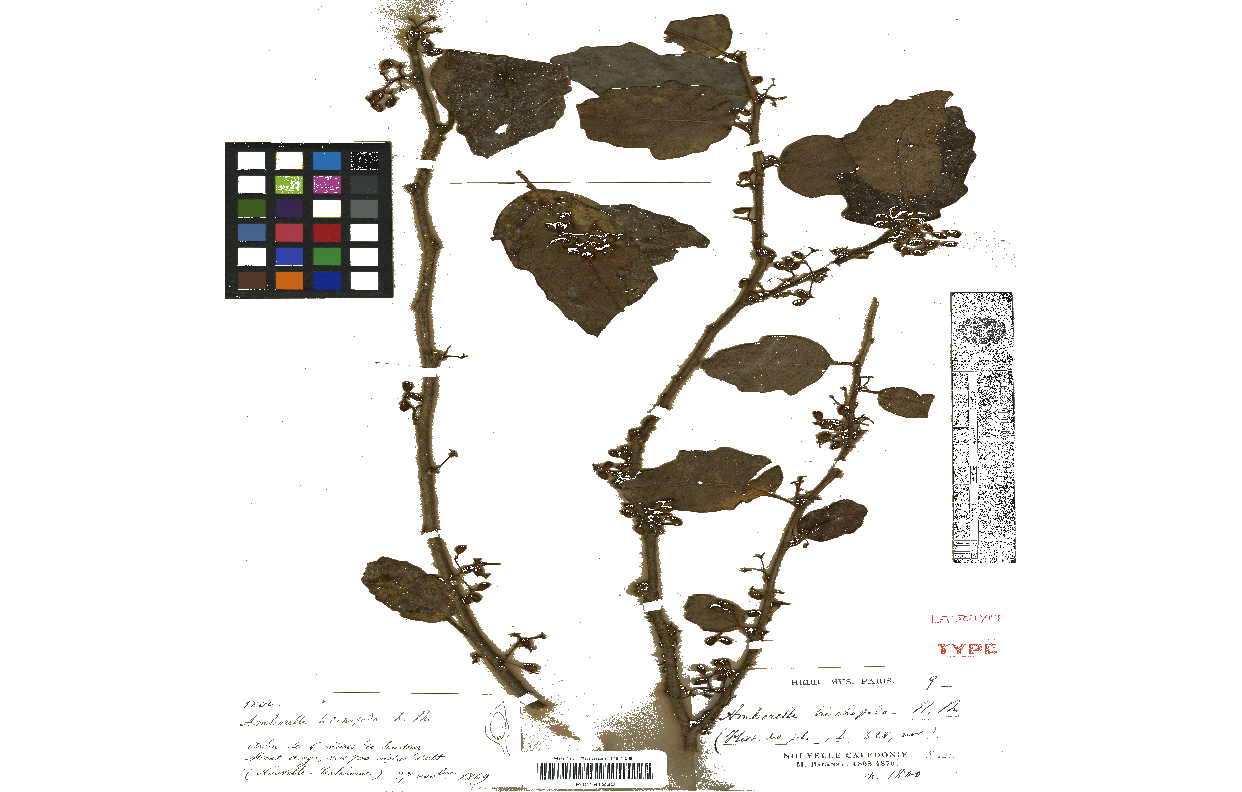

[[     0  54442]
 [     1 818309]
 [     2  27935]
 [     3  80860]
 [     4   2118]]
(255, 255, 255)


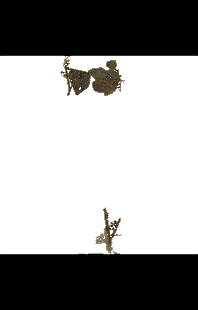

t


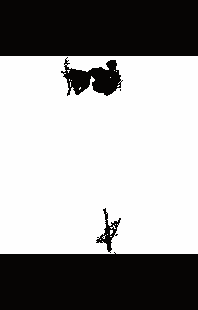

In [44]:
image = cv2.imread('/content/drive/MyDrive/Projet/Train/amborella/amborella098.jpg')

preprocessing(image)